In [582]:
import os
import numpy as np
import tensorflow as tf
import keras.metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scipy import ndimage
from model import ParticleClassifier

In [6]:
# Adds Precision and Recall metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [7]:
def load_data(path):
    # Loading in data
    data = np.genfromtxt(path, delimiter=',')
    labels = data[:,0]
    images = data[:, 1:].reshape((len(data),50,50,1))
    return images, labels

In [8]:
path = 'data/toy_data.csv'
images, labels = load_data(path)
images.shape

(3000, 50, 50, 1)

In [580]:
classifier = ParticleClassifier()\
                .load_data('data/toy_data.csv')\
                .train_test_split()\
                .pre_proc_train()\
                .pre_proc_test()\
                .one_hot_encode_labels()\
                .train_model()\
                .evaluate_model()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train images pre-processed into self.x_train
Test images pre-processed into self.x_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 7s 3ms/sample - loss: 0.6098 - acc: 0.7021 - val_loss: 0.3373 - val_acc: 0.8750
Epoch 2/10
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.2459 - acc: 0.9130 - val_loss: 0.1844 - val_acc: 0.9312
Epoch 3/10
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.1900 - acc: 0.9271 - val_loss: 0.1480 - val_acc: 0.9542
Epoch 4/10
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.1428 - acc: 0.9495 - val_loss: 0.1622 - val_acc: 0.9396
Epoch 5/10
1920/1920 [==============================] - 4s 2ms/sample - loss: 0.1190 - acc: 0.9526 - val_loss: 0.2563 - val_acc: 0.

### Data Pre-Processing

In [453]:
def pre_proc_rescale(images):
    # Subtract the mean, remove all negative values and scale following the max of each image
    orig_shape = images.shape
    images_reshaped = images.reshape((orig_shape[0], -1))
    images_scaled = np.subtract(images_reshaped, np.median(images_reshaped, axis=1, keepdims=True))
    images_scaled[images_scaled < 0] = 0.
    images_scaled = np.divide(images_scaled, np.max(images_scaled, axis=1, keepdims=True))
    images_scaled = images_scaled.reshape(orig_shape)
    return images_scaled

def pre_proc_filter(images):
    images_new = []
    for image in images.reshape((images.shape[0:-1])):        
        image_new = ndimage.median_filter(image, size=2, mode='wrap')
        image_new = ndimage.gaussian_filter(image_new, sigma=2)
        images_new.append(image_new)
    return np.array(images_new).reshape(images.shape)

In [109]:
def gen_hot_channel_data(images, value=None):
    if value == None:
        value = np.max(images) * 2
    loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
    images_edited = images.copy()
    images_edited[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = value
    return images_edited

### Building the Model

In [469]:
def model_train(x, y, val_split=0.2, epochs=10, verbose=1):
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 50x50 with 1 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    callback = EarlyStopping(monitor='val_acc',
                             min_delta=0.05,
                             patience=4)
    
    model.fit(
      x,
      y,  
      epochs=epochs,
      verbose=verbose,
      validation_split=val_split,
      callbacks=[callback])
    
    return model

In [461]:
history = model.fit(
      x_train,
      y_train,  
      epochs=10,
      verbose=1,
      validation_split=0.2
)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
1760/1920 [==========================>...] - ETA: 0s - loss: 0.0172 - acc: 0.9943

KeyboardInterrupt: 

In [11]:
model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

600/600 [==============================] - 0s 719us/sample - loss: 0.0605 - acc: 0.9867
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       210
           1       0.99      0.99      0.99       201
           2       0.99      0.97      0.98       189

   micro avg       0.99      0.99      0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



### Single Pixel Attack

In [370]:
def modify_pixel(images, x, y, value=0.):
    images_copy = images.copy()
    images_copy[:,x,y,0] = value
    return images_copy


def attack():
    # Builds the model
    path = 'data/toy_data.csv'
    images, labels = load_data(path)
    # Adds random hot channels into the data set
    #images_atk = np.append(images, gen_hot_channel_data(images), axis=0)
    #labels_atk = np.append(labels, labels)
    #images_train, images_test, labels_train, labels_test = train_test_split(images_atk, labels_atk, test_size=0.2)
    images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2)
    x_train = pre_proc_rescale(pre_proc_filter(images_train))
    x_test = pre_proc_rescale(pre_proc_filter(images_test))
    y_train = to_categorical(labels_train)
    y_test = to_categorical(labels_test)
    model = model_train(x_train, y_train, val_split=0.2, epochs=10, verbose=2)
    
    # Show model metrics on test set
    model.evaluate(x_test, y_test)
    y_pred = model.predict(x_test)
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    
    # Single Pixel Attack with dead (value=0) and hotwire()
    #dead = single_pixel_attack(model, images_test, x_test, 0)
    hot_pix = single_pixel_attack(model, images_test, x_test, y_test, 3 * np.max(images_test.flatten()))
    
    return hot_pix

def single_pixel_attack(model, images, x, y, value):
    # Attack each pixel
    image_dimensions = (images.shape[1], images.shape[2])
    change = np.zeros(image_dimensions)
    orig_pred = np.argmax(model.predict(x), axis=1)
    images_atttacked = gen_hot_channel_data(images)
    x_attacked = pre_proc_rescale(pre_proc_filter(images_attacked))
    new_pred = np.argmax(model.predict(x_attacked), axis=1)
    wrong_pred = np.size(orig_pred) - np.count_nonzero(np.equal(orig_pred, new_pred))
    print(wrong_pred, images.shape)
    
    '''
    for i in range(image_dimensions[0]):
        for j in range(image_dimensions[1]):
            images_attacked = modify_pixel(images, i, j, value=value)
            x_attacked = pre_proc_rescale(pre_proc_filter(images_attacked))
            new_pred = np.argmax(model.predict(x_attacked), axis=1)
            wrong_pred = np.size(orig_pred) - np.count_nonzero(np.equal(orig_pred, new_pred))
            change[i,j] = wrong_pred
            print(i, j, ': ', wrong_pred)
    '''
    return 

hot_pix = attack()

Train on 1920 samples, validate on 480 samples


KeyboardInterrupt: 

In [462]:
path = 'data/toy_data.csv'
images, labels = load_data(path)

In [470]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2)
x_train = pre_proc_rescale(pre_proc_filter(images_train))
x_test = pre_proc_rescale(pre_proc_filter(images_test))
y_train = to_categorical(labels_train)
y_test = to_categorical(labels_test)
model = model_train(x_train, y_train, val_split=0.2, epochs=10, verbose=2)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
 - 4s - loss: 0.5632 - acc: 0.7266 - val_loss: 0.1898 - val_acc: 0.9333
Epoch 2/10
 - 2s - loss: 0.1867 - acc: 0.9292 - val_loss: 0.1764 - val_acc: 0.9375
Epoch 3/10
 - 2s - loss: 0.1421 - acc: 0.9531 - val_loss: 0.2128 - val_acc: 0.9271
Epoch 4/10
 - 2s - loss: 0.1440 - acc: 0.9521 - val_loss: 0.1489 - val_acc: 0.9396
Epoch 5/10
 - 2s - loss: 0.1334 - acc: 0.9526 - val_loss: 0.1415 - val_acc: 0.9479


In [474]:
i=0
print(images_test.shape)
images_attacked = gen_hot_channel_data(images_test)
x_attacked = pre_proc_rescale(pre_proc_filter(images_attacked))
atk_pred = np.argmax(model.predict(x_attacked), axis=1)
org_pred = np.argmax(model.predict(x_test), axis=1)
diff = np.equal(atk_pred, org_pred)
print(diff.sum())
plt.imshow(x_attacked[~diff][i,:,:,0])
plt.show()
plt.imshow(x_test[~diff][i,:,:,0])
plt.show()
plt.imshow(images_test[~diff][i,:,:,0])
np.equal(x_attacked, x_test).sum()
print(y_test[~diff][i], org_pred[~diff][i], atk_pred[~diff][i])
print(np.unravel_index(x_attacked[~diff].argmax(), (50,50)))

(600, 50, 50, 1)
600


IndexError: index 0 is out of bounds for axis 0 with size 0

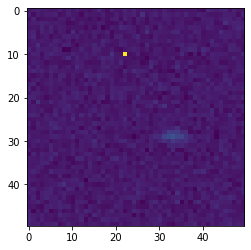

[[100.53  98.41  93.  ]
 [102.03 102.92  99.65]
 [100.4   94.31  99.15]
 [100.48 108.45  98.05]]


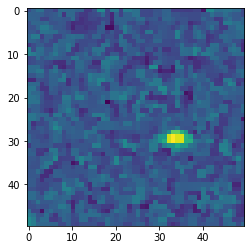

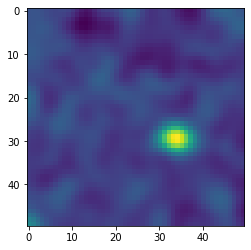

In [455]:
img = images_test[~diff][1,:,:,0]
plt.imshow(img)
img[10, 22] = 320
plt.imshow(img)
plt.show()
print(img[38:42, 0:3])
img = np.log(img)
img = ndimage.median_filter(img, size=2)
plt.imshow(img)
plt.show()
img = ndimage.gaussian_filter(img, sigma=2)
plt.imshow(img)

In [383]:
print(np.bincount(np.argmax(atk_pred, axis=1)))
np.bincount(np.argmax(org_pred, axis=1))

[177 219 204]


array([189, 200, 211])

321.56


(14, 34)

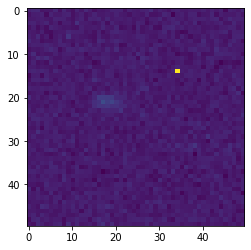

In [161]:
i = 3000
plt.imshow(images_atk[i][i,:,:,0])
print(images_atk[i].max())
np.unravel_index(images_atk[i].argmax(), (50,50))

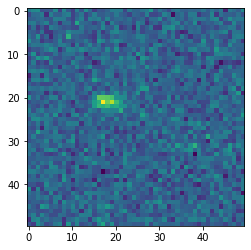

In [163]:
plt.imshow(images_atk[0,:,:,0]).imshow

100.89


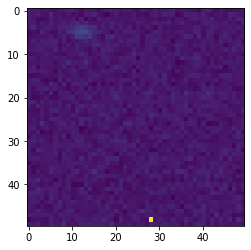

[0. 1. 0.]
2


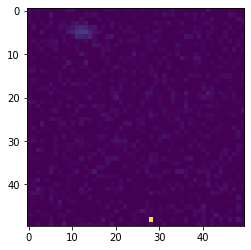

In [210]:
j=1418
plt.imshow(images_test[j,:,:,0])
print(images_test[j,12,5,0])
plt.show()
plt.imshow(x_test[j,:,:,0])
print(y_test[j])
print(atk_pred[j])

In [146]:
images_atk[4, 35, 35]

array([137.27])

In [195]:
print(np.bincount(atk_pred))
print(np.equal(atk_pred, np.argmax(y_test, axis=1)).sum())
print(atk_pred.shape)

[1210  569  621]
777
(2400,)


125.55
2.0


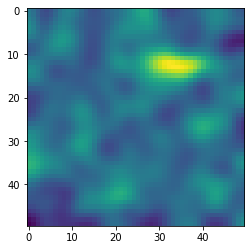

In [272]:
k = 1994
images_eroded = ndimage.median_filter(images[k,:,:,0], size=3)
images_eroded = ndimage.gaussian_filter(images_eroded, sigma=2)
print(images[k,:,:,0].max())
print(labels[k])
plt.imshow(images_eroded)

125.55
2.0


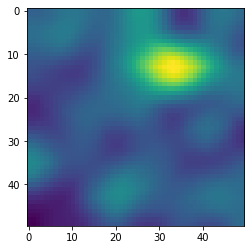

In [275]:
k = 1994
images_eroded = ndimage.gaussian_filter(images[k,:,:,0], sigma=4)
images_eroded = ndimage.median_filter(images_eroded, size=2)
print(images[k,:,:,0].max())
print(labels[k])
plt.imshow(images_eroded)

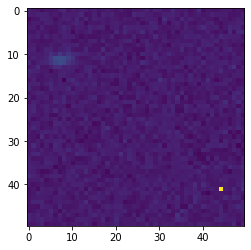

(3000, 50, 50)


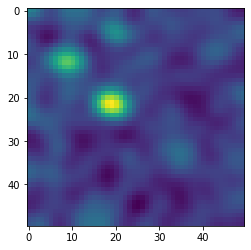

In [295]:
k = 1
images_attacked = gen_hot_channel_data(images)
plt.imshow(images_attacked[k,:,:,0])
plt.show()
image_filtered = ndimage.median_filter(images_attacked[:,:,:,0], size=2)
image_filtered = ndimage.gaussian_filter(image_filtered, sigma=2)
print(image_filtered.shape)
plt.imshow(image_filtered[k])

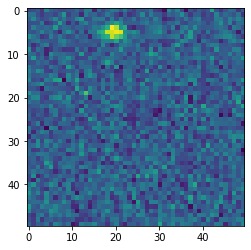

In [358]:
path = 'data/toy_data.csv'
images, labels = load_data(path)
plt.imshow(images[15,:,:,0])
images_new = []
for image in images:
    image_new = ndimage.median_filter(image, size=2)
    image_new = ndimage.gaussian_filter(image_new, sigma=2)
    images_new.append(image_new)
images_new = np.array(images_new)

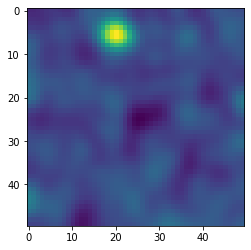

In [359]:
plt.imshow(images_new[15,:,:,0])

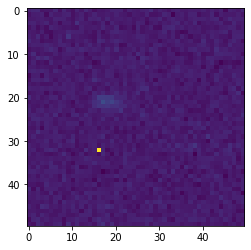

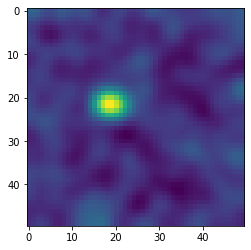

In [363]:
images_atk = gen_hot_channel_data(images)
plt.imshow(images_atk[0,:,:,0])
plt.show()
images_new = pre_proc_filter(images_atk)
images_new.shape
plt.imshow(images_new[0])

### Jacobian-based Saliency Map Attack

In [12]:
from cleverhans.attacks import SaliencyMapMethod
#from cleverhans.compat import flags
from cleverhans.dataset import MNIST
from cleverhans.loss import CrossEntropy
from cleverhans.utils import other_classes, set_log_level
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils_tf import model_eval, model_argmax
from cleverhans.train import train


In [13]:
#jsma = SaliencyMapMethod(model)

TypeError: The model argument should be an instance of the cleverhans.model.Model class.